In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
POISS_SUPP = 50
torch.set_default_dtype(torch.float64)

In [3]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=6, num_component_output=2):
        super(NeuralNetwork, self).__init__()
        self.input_size = input_size
        self.num_component_output = num_component_output
        self.flatten = nn.Flatten()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,6)
        )

    def forward(self, x):
        output = self.network(x)
        pi = output[:, 0:self.num_component_output]
        mu = output[:, self.num_component_output:2*self.num_component_output]
        sigma = output[:, 2*self.num_component_output:3*self.num_component_output]

        pi = torch.softmax(pi, dim=1)
        sigma = torch.exp(sigma)
        mu = torch.exp(mu)

        return mu, pi, sigma



In [3]:
def loss_function(old_pi, old_mu, old_sigma, new_pi, new_mu, new_sigma, n_samples):

    # Generate samples from the old gaussian mixture
    mix = torch.distributions.Categorical(old_pi)
    comp = torch.distributions.Normal(old_mu, old_sigma)
    gmm = torch.distributions.MixtureSameFamily(mix, comp)

    j = 0
    while j < n_samples:
        new_sample = gmm.sample()
        if new_sample >= 0:
            if(j == 0):
                y = torch.tensor([new_sample]).reshape(1)
            else:
                y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
            j += 1
    
    y_poisson = torch.distributions.Poisson(y).sample((y.shape[0],))

    #Generate the new gaussian mixture
    mix_new = torch.distributions.Categorical(new_pi)
    comp_new = torch.distributions.Normal(new_mu, new_sigma)
    gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
    # Calculate the log likelihood of the new gaussian mixture with the old samples
    log_likelihood = 0
    for i in range(len(y_poisson)):
        #log_likelihood += torch.log(torch.sum(gmm_new.log_prob(y_poisson[i]).exp()))
        log_likelihood += torch.logsumexp(gmm_new.log_prob(y_poisson[i]), dim=0)
    return -log_likelihood


In [4]:
# Define the number of samples in the dataset
num_samples = 10

from scipy.stats import qmc

l_bound_pi = [0]
u_bound_pi = [1]
l_bound_mu = [0]
u_bound_mu = [2]
l_bound_sigma = [0.01]
u_bound_sigma = [1]

sampler = qmc.LatinHypercube(d=1)

p1 = sampler.random(n=10)
mu1 = sampler.random(n=10)
mu2 = sampler.random(n=10)
sigma1 = sampler.random(n=10)
sigma2 = sampler.random(n=10)

p1 = qmc.scale(p1, l_bound_pi, u_bound_pi)
mu1 = qmc.scale(mu1, l_bound_mu, u_bound_mu)
mu2 = qmc.scale(mu2, l_bound_mu, u_bound_mu)
sigma1 = qmc.scale(sigma1, l_bound_sigma, u_bound_sigma)
sigma2 = qmc.scale(sigma2, l_bound_sigma, u_bound_sigma)


for i in range(len(p1)):
    for j in range(len(mu1)):
        for k in range(len(mu2)):
            for l in range(len(sigma1)):
                for m in range(len(sigma2)):
                    if(i == 0 and j == 0 and k == 0 and l == 0 and m == 0):
                        dataset = torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float64).flatten()
                    else:
                        dataset = torch.vstack((dataset,torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float64).flatten()))

#dataset = torch.tensor(dataset)
print(len(dataset))
# split the dataset into training and test shuffling the dataset
dataset=dataset[torch.randperm(dataset.size()[0])]


/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_56709/2442882499.py:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/torch/csrc/utils/tensor_new.cpp:278.)
  dataset = torch.tensor([p1[i], 1-p1[i], mu1[j], mu2[k], sigma1[l], sigma2[m]]).type(torch.float64).flatten()


100000


In [13]:
def train_loop(training_data, model, loss_fn, optimizer):
    model.train()
    counter = 0
    for gaussian_mix_old in training_data:
        # Compute prediction and loss
        
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        mu_new, pi_new, sigma_new = model(gaussian_mix_old.reshape(1,6))
    
        loss = loss_fn(old_pi, old_mu, old_sigma, pi_new, mu_new, sigma_new, 10)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 10000 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1


def test_loop(test_data, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for gaussian_mix_old in test_data:
            old_pi = gaussian_mix_old[0:2]
            old_mu = gaussian_mix_old[2:4]
            old_sigma = gaussian_mix_old[4:6]
            mu_new, pi_new, sigma_new = model(torch.tensor(gaussian_mix_old))

            # Generate samples from the old gaussian mixture
            # A stream of indices from which to choose the component
            mixture_idx = np.random.choice(len(old_pi), size=10, replace=True, p=old_pi)
            # y is the mixture sample
            y = np.fromiter((ss.norm.rvs(old_mu[i], old_sigma[i]) for i in mixture_idx),
                        dtype=np.float64)
            y_poisson = np.fromiter((ss.poisson.rvs(y[i]) for i in y),
                   dtype=np.float64)
    
            test_loss += loss_fn(old_pi, old_mu, old_sigma, pi_new, mu_new, sigma_new, y_poisson)


            test_loss /= len(test_data)
            print(f"Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 5
model = NeuralNetwork(num_component_input=2, num_component_output=2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataset, model, loss_function, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 34.909679
loss: 3.704840
loss: -1.458590
loss: -0.929363
loss: 1.658993
loss: -0.931202
loss: -8.842523
loss: 10.382759
loss: -5.155351
loss: -1.389900
Epoch 2
-------------------------------
loss: 1.708147
loss: -0.473177
loss: -4.109357
loss: -0.508894
loss: 1.268651
loss: 1.581941
loss: -5.338694
loss: 5.570471
loss: -5.421062
loss: -3.381277
Epoch 3
-------------------------------
loss: -0.010734
loss: -1.508446
loss: -5.118939
loss: -0.571004
loss: 7.162217
loss: -2.232449
loss: -8.734086
loss: 3.058240
loss: -4.099992
loss: -5.017231
Epoch 4
-------------------------------
loss: 3.134861
loss: -2.832657
loss: -1.295374
loss: -0.763942
loss: 1.080817
loss: 6.463945
loss: -5.090220
loss: 3.000602
loss: -5.527108
loss: -4.010235
Epoch 5
-------------------------------
loss: 2.157034
loss: -3.045451
loss: -4.562458
loss: -0.689327
loss: 11.434970
loss: 2.632011
loss: -4.757775
loss: 4.783462
loss: -5.455184
loss: -7.023130
Done!


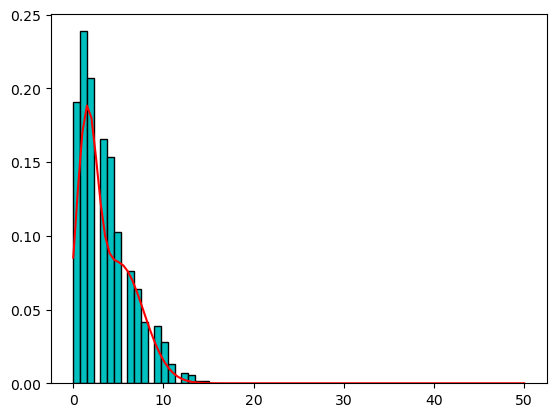

In [65]:
#Check with some distributions
pi = torch.tensor([0.5, 0.5]).type(torch.float32)
mu = torch.tensor([1.1, 4.3]).type(torch.float32)
sigma = torch.tensor([1.5, 2.3]).type(torch.float32)
mix = torch.distributions.Categorical(pi)
comp = torch.distributions.Normal(mu, sigma)
gmm = torch.distributions.MixtureSameFamily(mix, comp)

j = 0
while j < 1000:
    new_sample = gmm.sample()
    if new_sample >= 0:
        if(j == 0):
            y = torch.tensor([new_sample]).reshape(1)
        else:
            y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
        j += 1

y_poisson = torch.distributions.Poisson(y).sample()
y_poisson_np = y_poisson.numpy()
plt.hist(y_poisson_np, bins=20, color='c', edgecolor='black', density=True)

mu_new, pi_new, sigma_new = model(torch.cat((pi,mu,sigma), dim=0).reshape(1,6))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 50, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 50, 100)).reshape(100,1)).exp().detach().numpy(), color='r')

In [17]:
torch.save(model, 'model1.pth')

In [5]:
training_data = dataset[:int(0.9*len(dataset))]

In [5]:
def loss_function_minibatch(gaussian_mixtures, new_pi, new_mu, new_sigma, n_samples):
    count = 0
    total_loss = 0
    for gaussian_mix_old in gaussian_mixtures:
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        
        # Generate samples from the old gaussian mixture
        mix = torch.distributions.Categorical(old_pi)
        comp = torch.distributions.Normal(old_mu, old_sigma)
        gmm = torch.distributions.MixtureSameFamily(mix, comp)

        j = 0
        while j < n_samples:
            new_sample = gmm.sample()
            if new_sample >= 0:
                if(j == 0):
                    y = torch.tensor([new_sample]).reshape(1)
                else:
                    y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
                j += 1
        
        y_poisson = torch.distributions.Poisson(y).sample()

        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(y_poisson))
        total_loss -= log_likelihood
        count += 1
    return total_loss/count


In [6]:
def train_loop_minibatch(training_dataloader, model, loss_fn, optimizer):
    model.train()
    counter = 0
    
    for bach_idx, gaussian_mixtures in enumerate(training_dataloader):
        
        mu_new, pi_new, sigma_new = model(gaussian_mixtures)
        loss = loss_fn(gaussian_mixtures, pi_new, mu_new, sigma_new, 50)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1

In [9]:
epochs = 5
#model = NeuralNetwork(num_component_input=2, num_component_output=2)
model = torch.load('model2.pth')
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
train_dataloader = DataLoader(training_data, batch_size=64)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch(train_dataloader, model, loss_function_minibatch, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")

Epoch 1
-------------------------------
loss: 86.177010
loss: 76.949051
loss: 75.285011
loss: 74.319077
loss: 74.954086
loss: 73.277496
loss: 74.385994
loss: 73.790947
loss: 73.442886
loss: 73.957176
loss: 74.143593
loss: 74.230705
loss: 74.790199
loss: 71.003014
loss: 73.018867
Epoch 2
-------------------------------
loss: 72.643227
loss: 73.029152
loss: 72.883095
loss: 71.502548
loss: 72.532295
loss: 71.903969
loss: 72.343445
loss: 72.298332
loss: 71.801651
loss: 71.669609
loss: 74.297791
loss: 72.852432
loss: 75.011703
loss: 69.046951
loss: 71.154526
Epoch 3
-------------------------------
loss: 69.354584
loss: 72.461082
loss: 71.938904
loss: 70.221413
loss: 71.770676
loss: 71.407120
loss: 72.751724
loss: 71.996811
loss: 70.625793
loss: 72.615440
loss: 73.800827
loss: 73.444267
loss: 75.556015
loss: 70.746300
loss: 69.926132
Epoch 4
-------------------------------
loss: 70.630318
loss: 72.874611
loss: 71.023811
loss: 70.561859
loss: 71.019119
loss: 69.729179
loss: 71.903763
loss: 71

(0.0, 1.0)

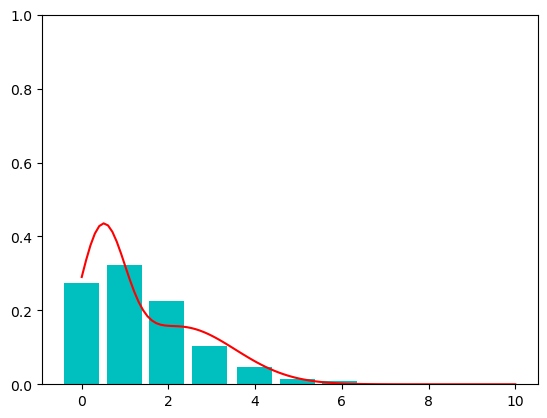

In [10]:
#Check with some distributions
pi = torch.tensor([0.5, 0.7]).type(torch.float32)
mu = torch.tensor([0.95, 1.73]).type(torch.float32)
sigma = torch.tensor([0.05, 0.64]).type(torch.float32)
mix = torch.distributions.Categorical(pi)
comp = torch.distributions.Normal(mu, sigma)
gmm = torch.distributions.MixtureSameFamily(mix, comp)

j = 0
while j < 1000:
    new_sample = gmm.sample()
    if new_sample >= 0:
        if(j == 0):
            y = torch.tensor([new_sample]).reshape(1)
        else:
            y = torch.cat((y, torch.tensor([new_sample]).reshape(1)), dim= 0)
        j += 1

y_poisson = torch.distributions.Poisson(y).sample()
y_poisson_np = y_poisson.numpy()
#plt.hist(y_poisson_np, bins=100, density=True)
hist = np.histogram(y_poisson_np, density=True)
plt.bar(hist[1][:-1], hist[0]/np.sum(hist[0]), color='c')

mu_new, pi_new, sigma_new = model(torch.cat((pi,mu,sigma), dim=0).reshape(1,6))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 10, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 10, 100)).reshape(100,1)).exp().detach().numpy(), color='r')
plt.ylim(0, 1)

In [11]:
torch.save(model, 'model3.pth')

In [6]:
import torch.nn.functional as F
from torch.distributions.normal import Normal

def generate_poisson(pi, mu, sigma, end = POISS_SUPP):
    """
    Input:
    pi = tensor of weights of length c
    mu = tensor of means of length c
    sigma = tensor of variances of length c
    Taken as input the parameters of a Gaussian Mixtures returns the
    density of a Poisson distribution having as rate given mixture, truncated to [0, end]
    """
    c = len(pi)   # number of components in the mixture
    
    # initializes the density vector, storing a density for each component
    pois_dens = torch.zeros((c, end))
    # initializes the vector of factorials
    log_fact = torch.tensor([sum([torch.log(torch.tensor(float(i))) for i in range(1, n)]) for n in range(1, end+1)])
    
    # computes the Gaussian density for each component
    muprime = mu - sigma
    std = torch.sqrt(sigma)
    norm = Normal(torch.tensor(0.0), torch.tensor(1.0))

    for i in range(c):
        for k_val in range(end):
            if k_val == 0:
                pois_dens[i, k_val] = 1 - norm.cdf(-muprime[i]/std[i])
            elif k_val == 1:
                pois_dens[i, k_val] = muprime[i] * pois_dens[i, k_val-1] + std[i] * norm.log_prob(-muprime[i]/std[i]).exp()
            else:
                pois_dens[i, k_val] = (muprime[i] * pois_dens[i, k_val-1] + (k_val-1) * sigma[i] * pois_dens[i, k_val-2])
        # goes to logarithm to compute the factorial
        pois_dens[i, :] = torch.log(pois_dens[i, :]) - log_fact
        pois_dens[i, :] = pois_dens[i, :].exp()
        # multiplies by normalization constant
        pois_dens[i, :] = pois_dens[i, :] * torch.exp(0.5 * (sigma[i] - 2 * mu[i]))
        # puts missing probability mass to zero
        pois_dens[i, 0] += 1 - pois_dens[i, :].sum()

    # compute product between weights and densities per component
    pois_dens = pi.reshape(1, c).matmul(pois_dens).reshape(end, )
    return pois_dens


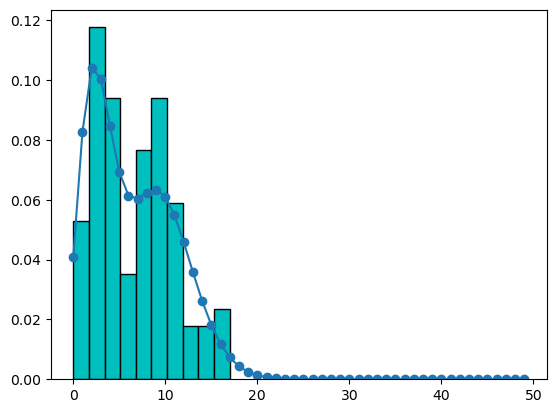

In [7]:
pi = torch.tensor([0.5, 0.5])
mu = torch.tensor([3, 10])
sigma = torch.tensor([1, 1])

pois_dens = generate_poisson(pi, mu, sigma)
pois_dens

#sample 100 points from a categorical distribution with the weights pois_dens
sample = torch.distributions.Categorical(probs=pois_dens).sample((100,))

plt.hist(sample, bins=10, density=True, color='c', edgecolor='black')
plt.plot(range(50), pois_dens, marker= 'o')


In [16]:
def loss_function_minibatch_poisson(y_poisson, new_pi, new_mu, new_sigma):
    count = 0
    total_loss = 0
    for poisson_sample in y_poisson:
        #Generate the new gaussian mixture
        mix_new = torch.distributions.Categorical(new_pi[count])
        comp_new = torch.distributions.Normal(new_mu[count], new_sigma[count])
        gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

    
        # Calculate the log likelihood of the new gaussian mixture with the old samples
        log_likelihood = torch.sum(gmm_new.log_prob(poisson_sample))
        total_loss -= log_likelihood
        count += 1
    return total_loss/count


In [9]:
def train_loop_minibatch_poisson(training_dataloader, model, loss_fn, optimizer, n_samples=50):
    model.train()
    counter = 0
    
    for bach_idx, poisson_denisties in enumerate(training_dataloader):
        y_poisson = []

        for density in poisson_denisties:
            y_poisson.append(torch.distributions.Categorical(probs=density).sample((n_samples,)))
            mu_new, pi_new, sigma_new = model(poisson_denisties)
            
        loss = loss_fn(y_poisson, pi_new, mu_new, sigma_new)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if counter % 100 == 0:
            loss = loss.item() #batch * batch_size + len(X)
            print(f"loss: {loss:>7f}")
        counter += 1



In [10]:
training_data = dataset[:int(0.8*len(dataset))]

#build a tensor that replaces each of the rows of the training_data with the corresponding generate_poisson


def generate_poisson_dataset(training_data):
    y_poisson = []
    poisson_denisties = []
    for gaussian_mix_old in training_data:
        old_pi = gaussian_mix_old[0:2]
        old_mu = gaussian_mix_old[2:4]
        old_sigma = gaussian_mix_old[4:6]
        pois_dens = generate_poisson(old_pi, old_mu, old_sigma)
        y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((50,)))
        poisson_denisties.append(pois_dens)
    return torch.stack(poisson_denisties),torch.stack(y_poisson)


densities, y_poisson = generate_poisson_dataset(training_data)

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_56709/2146294935.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_poisson.append(torch.distributions.Categorical(probs=torch.tensor(pois_dens)).sample((50,)))


In [11]:
densities

tensor([[2.3510e-01, 2.6954e-01, 2.2114e-01,  ..., 1.3106e-31, 1.7557e-32,
         2.3261e-33],
        [7.2710e-01, 1.6137e-01, 7.1045e-02,  ..., 3.1228e-40, 3.0172e-41,
         2.8870e-42],
        [6.9166e-01, 1.8454e-01, 7.8911e-02,  ..., 2.3583e-35, 2.8196e-36,
         3.3356e-37],
        ...,
        [3.2019e-01, 2.6197e-01, 2.0598e-01,  ..., 4.3406e-37, 4.8896e-38,
         5.4535e-39],
        [5.5750e-01, 2.7075e-01, 1.1501e-01,  ..., 1.4507e-41, 1.2048e-42,
         9.8977e-44],
        [5.3276e-01, 2.6646e-01, 1.2678e-01,  ..., 3.0412e-35, 3.7183e-36,
         4.5002e-37]])

In [17]:
epochs = 10
model = NeuralNetwork(input_size=POISS_SUPP, num_component_output=2)

optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)
train_dataloader = DataLoader(densities, batch_size=32)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop_minibatch_poisson(train_dataloader, model, loss_function_minibatch_poisson, optimizer)
    #test_loop(test_data, model, loss_function)
print("Done!")
torch.save(model, 'model4.pth')

Epoch 1
-------------------------------
loss: 89.499065
loss: 88.550458
loss: 88.150365
loss: 80.131909
loss: 85.068233
loss: 81.285146
loss: 87.233602
loss: 83.604737
loss: 79.888679
loss: 84.791013
loss: 83.345208
loss: 82.807139
loss: 79.740313
loss: 83.763502
loss: 81.161354
loss: 83.996864
loss: 83.023893
loss: 84.184215
loss: 79.793756
loss: 81.098761
loss: 82.952388
loss: 83.878014
loss: 81.429515
loss: 80.987610
loss: 81.202451
Epoch 2
-------------------------------
loss: 84.185803
loss: 81.866295
loss: 84.708713
loss: 79.917259
loss: 80.166791
loss: 81.565069
loss: 81.786375
loss: 80.585508
loss: 80.127217
loss: 78.310848
loss: 82.244664
loss: 83.891298
loss: 76.252070
loss: 80.192826
loss: 78.015966
loss: 79.723374
loss: 80.823029
loss: 80.331839
loss: 77.736132
loss: 79.520125
loss: 78.285597
loss: 79.898482
loss: 77.755360
loss: 78.212148
loss: 78.429412
Epoch 3
-------------------------------
loss: 80.060201
loss: 78.998303
loss: 78.993491
loss: 75.950605
loss: 78.866462


(0.0, 1.0)

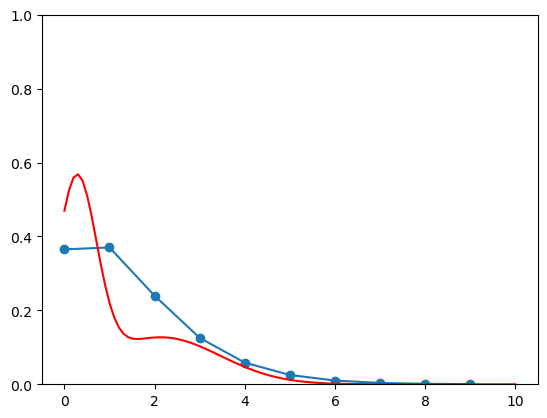

In [20]:
#Check with some distributions
pi = torch.tensor([0.5, 0.7])
mu = torch.tensor([0.95, 1.73])
sigma = torch.tensor([0.05, 0.64])

pois_dens = generate_poisson(pi, mu, sigma)
plt.plot(range(10), pois_dens[0:10], marker= 'o')

mu_new, pi_new, sigma_new = model(pois_dens.reshape(1,50))
mix_new = torch.distributions.Categorical(pi_new)
comp_new = torch.distributions.Normal(mu_new, sigma_new)
gmm_new = torch.distributions.MixtureSameFamily(mix_new, comp_new)

plt.plot(np.linspace(0, 10, 100), gmm_new.log_prob(torch.tensor(np.linspace(0, 10, 100)).reshape(100,1)).exp().detach().numpy(), color='r')
plt.ylim(0, 1)
